In [1]:
import cv2
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input
from keras.models import load_model


from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import BatchNormalization
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [2]:
from IPython.display import FileLinks, FileLink
#FileLinks(r'Data/')
#FileLink(r'./Midterm_Model.h5')

In [3]:
import shutil
import os 
#shutil.rmtree("/kaggle/working/lr0.0001_epochs220")
#os.remove('./MyModel.h5')
#os.remove('./lr0.0001_epochs220.h5')

In [4]:
# Check if tensorflow detectects the gpu or not
if tf.test.gpu_device_name():
    print("Gpu available: {}".format(tf.test.gpu_device_name()))
else:
    print("Tensor Flow has not detected the gpu")

Gpu available: /device:GPU:0


In [5]:
#inputImg = []
#inputImg.append(pd.read_csv('Data/all_lc_converted_to_test1_senior_format.csv', delimiter=','))
#imputdata = pd.read_csv('Data/all_lc_converted_to_test1_senior_format.csv', delimiter=',')
#print(len(inputImg))
## Split into train and validation set
#train_inputImg ,val_test_inputImg = train_test_split(imputdata,test_size=0.2, random_state=42)



In [6]:
# Function to preprocess the image
def preprocess_image(image):
    # Enhance edges using adaptive histogram equalization (CLAHE)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_image = clahe.apply(image)
    
    # Apply a bilateral filter to remove noise while keeping edges sharp
    filtered_image = cv2.bilateralFilter(enhanced_image, d=9, sigmaColor=75, sigmaSpace=75)
    
    return enhanced_image, filtered_image

(256, 256, 1)
(256, 256)


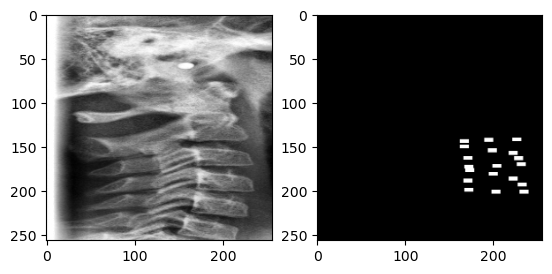

In [7]:
train_inputImg = pd.read_csv('Data/train_data.csv', delimiter=',')

w = 5
train_images = []
masks = []
train_masks = []

train_images_filtered = []


for row in train_inputImg.values:
    img_landmarks = list(row)
    image = cv2.imread('Data/ROI images/' + img_landmarks[0],0) 
    Mask_Image = np.zeros((image.shape[0],image.shape[1],1))
    
    for i in range(1,38,2):
        x = int(img_landmarks[i])
        y = int(img_landmarks[i+1])
        Mask_Image[y-w:y+w , x-w:x+w ,0] = 1
    
    masks.append(Mask_Image)

    new_image = cv2.resize(image,(256,256))
    new_image = new_image.reshape((new_image.shape[0],new_image.shape[1],1))
    #improve the image features 
    enhanced_image, filtered_image = preprocess_image(new_image)

    train_images.append(enhanced_image/255)
    train_images_filtered.append(filtered_image/255)


    resize_mask=cv2.resize(Mask_Image,(256,256))
    train_masks.append(resize_mask)

size=new_image.shape
print(size)
print (train_images[0].shape)
plt.subplot(121)
plt.imshow(train_images[0], cmap='gray')
plt.subplot(122)
plt.imshow(train_masks[0], cmap='gray')

67
(256, 256, 1)
(256, 256)
(256, 256)


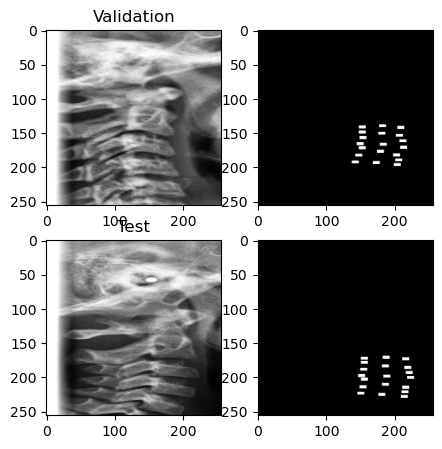

In [8]:
val_test_inputImg = pd.read_csv('Data/test_data.csv', delimiter=',')

plt.rcParams["figure.figsize"] = (5,5)

val_images = []
val_images_filtered = []
val_masks_orig = []
val_masks = []

test_images = []
test_images_filtered = []
test_masks_orig = []
test_masks = []

count = 1

print(len(val_test_inputImg))
for row in val_test_inputImg.values:
    img_landmarks = list(row)

   
    image = cv2.imread('Data/ROI images/' + img_landmarks[0], 0) 
    Mask_Image = np.zeros((image.shape[0],image.shape[1],1))
    
    for i in range(1,38,2):
        x = int(img_landmarks[i])
        y = int(img_landmarks[i+1])
        Mask_Image[y-w:y+w , x-w:x+w ,0] = 1
         

    new_image = cv2.resize(image,(256,256))
    new_image = new_image.reshape((new_image.shape[0],new_image.shape[1],1))
    #improve the image features 
    enhanced_image, filtered_image = preprocess_image(new_image)
    resize_mask=cv2.resize(Mask_Image,(256,256))
    

    
    if count <= 50:
        val_images.append(enhanced_image)
        val_images_filtered.append(filtered_image)
        val_masks_orig.append(Mask_Image)
        val_masks.append(resize_mask)
    else:
        test_images.append(enhanced_image)
        test_images_filtered.append(filtered_image)
        test_masks_orig.append(Mask_Image)
        test_masks.append(resize_mask) 
    
    count += 1
    
size=new_image.shape
print(size)
print (val_masks[0].shape)
print(val_images[0].shape)
plt.subplot(221)
plt.imshow(val_images[0], cmap='gray')
plt.title("Validation")
plt.subplot(222)
plt.imshow(val_masks[0], cmap='gray')

plt.subplot(223)
plt.imshow(test_images[0], cmap='gray')
plt.title("Test")
plt.subplot(224)
plt.imshow(test_masks[0], cmap='gray')

In [9]:
train_images_filtered_stacked = np.stack(train_images_filtered, axis=0)
train_images_stacked = np.stack(train_images, axis=0)
train_masks_stacked = np.stack(train_masks, axis=0)

val_images_stacked = np.stack(val_images, axis=0)
val_masks_stacked = np.stack(val_masks, axis=0)
val_data = (val_images_stacked, val_masks_stacked)

In [10]:
print(train_images_stacked.shape)
print(train_masks_stacked.shape)

(366, 256, 256)
(366, 256, 256)


In [11]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    """
    Convolutional downsampling block
    
    Arguments:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns: 
        next_layer, skip_connection --  Next layer and skip connection outputs
    """

    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(inputs)
    
    conv = BatchNormalization()(conv)
    
    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)
    conv = BatchNormalization()(conv)
    
    # if dropout_prob > 0 add a dropout layer, with the variable dropout_prob as parameter
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)
         
        
    # if max_pooling is True add a MaxPooling2D with 2x2 pool_size
    if max_pooling:
        next_layer = MaxPooling2D((2,2))(conv)
        
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

In [12]:
def upsampling_block(expansive_input, contractive_input, n_filters=32, output=False):
    """
    Convolutional upsampling block
    
    Arguments:
        expansive_input -- Input tensor from previous layer
        contractive_input -- Input tensor from previous skip layer
        n_filters -- Number of filters for the convolutional layers
    Returns: 
        conv -- Tensor output
    """
    
    up = Conv2DTranspose(
                 n_filters,    # number of filters
                 3,    # Kernel size
                 strides=2,
                 padding='same')(expansive_input)
    
    # Merge the previous output and the contractive_input
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(merge)
    conv = BatchNormalization()(conv)
        
    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)
    conv = BatchNormalization()(conv)
    
    if not output:
        conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)
        conv = BatchNormalization()(conv)
    
    return conv

In [13]:
def unet_model(input_size, n_filters=64, n_classes=2):
    """
    Unet model
    
    Arguments:
        input_size -- Input shape 
        n_filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes
    Returns: 
        model -- tf.keras.Model
    """
    inputs = Input(input_size)
    
    # Contracting Path (encoding)
    # Add a conv_block with the inputs of the unet_ model and n_filters
    cblock1 = conv_block(inputs, n_filters)
    
    # Chain the first element of the output of each block to be the input of the next conv_block. 
    # Double the number of filters at each new step
    cblock2 = conv_block(cblock1[0], n_filters*2)
    cblock3 = conv_block(cblock2[0], n_filters*4)
    cblock4 = conv_block(cblock3[0], n_filters*8, dropout_prob=0) # Include a dropout_prob of 0.3 for this layer
    # Include a dropout_prob of 0.3 for this layer, and avoid the max_pooling layer
    cblock5 = conv_block(cblock4[0], n_filters*16, dropout_prob=0, max_pooling=False) 
    
    # Expanding Path (decoding)
    # Add the first upsampling_block.
    # Use the cblock5[0] as expansive_input and cblock4[1] as contractive_input and n_filters * 8
    ublock6 = upsampling_block(cblock5[0], cblock4[1],  n_filters*8, False)
    
    # Chain the output of the previous block as expansive_input and the corresponding contractive block output.
    # Note that you must use the second element of the contractive block i.e before the maxpooling layer. 
    # At each step, use half the number of filters of the previous block 
    ublock7 = upsampling_block(ublock6, cblock3[1],  n_filters * 4, False)
    ublock8 = upsampling_block(ublock7, cblock2[1],  n_filters * 2, False)
    ublock9 = upsampling_block(ublock8, cblock1[1],  n_filters, True)

    #conv9 = Conv2D(n_filters,
    #             3,
    #             activation='relu',
    #             padding='same',
    #            kernel_initializer='he_normal')(ublock9)

    # Add a Conv2D layer with n_classes filter, kernel size of 1 and a 'same' padding
    conv10 = Conv2D(n_classes, kernel_size=1, activation='sigmoid', padding='same')(ublock9)
    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [14]:
epsilon = 1e-7
def dice_coeff(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + epsilon) / ( K.sum(y_true_f) + K.sum(y_pred_f) + epsilon)
    return dice

In [15]:
def dice_loss(y_true, y_pred):
    dice = dice_coeff(y_true, y_pred)
    return 1 - dice

In [16]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10)
checkpoint_filepath = 'checkpoint_20channels.kera'
checkpoint_20channels = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_dice_coeff',
    save_best_only=True)

In [17]:
print(size)
unet = unet_model(size, n_classes=1)

(256, 256, 1)


In [18]:
unet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=dice_loss,
              metrics=dice_coeff)

In [19]:

#model_history = unet.fit(train_images_stacked, train_masks_stacked, batch_size = 32, epochs=1000, validation_data=val_data, callbacks=[reduce_lr])
model_history = unet.fit(train_images_stacked, train_masks_stacked, batch_size = 32, epochs=2000, validation_data=val_data, callbacks=[reduce_lr])

Epoch 1/2000
12/12 [==============================] - 44s 2s/step - loss: 0.9386 - dice_coeff: 0.0628 - val_loss: 0.9752 - val_dice_coeff: 0.0248 - lr: 0.0010
Epoch 2/2000
12/12 [==============================] - 8s 645ms/step - loss: 0.9035 - dice_coeff: 0.0965 - val_loss: 0.9752 - val_dice_coeff: 0.0248 - lr: 0.0010
Epoch 3/2000
12/12 [==============================] - 8s 644ms/step - loss: 0.8874 - dice_coeff: 0.1123 - val_loss: 0.9752 - val_dice_coeff: 0.0248 - lr: 0.0010
Epoch 4/2000
12/12 [==============================] - 8s 645ms/step - loss: 0.8738 - dice_coeff: 0.1260 - val_loss: 0.9752 - val_dice_coeff: 0.0248 - lr: 0.0010
Epoch 5/2000
12/12 [==============================] - 8s 644ms/step - loss: 0.8632 - dice_coeff: 0.1374 - val_loss: 0.9752 - val_dice_coeff: 0.0248 - lr: 0.0010
Epoch 6/2000
12/12 [==============================] - 8s 646ms/step - loss: 0.8583 - dice_coeff: 0.1413 - val_loss: 0.9752 - val_dice_coeff: 0.0248 - lr: 0.0010
Epoch 7/2000
12/12 [================

In [20]:
unet.save('Midterm_Model_2000_enhanced_images.h5')

In [21]:
unet.save('Midterm_Model_2000_enhanced')

INFO:tensorflow:Assets written to: Midterm_Model_2000_enhanced\assets


INFO:tensorflow:Assets written to: Midterm_Model_2000_enhanced\assets


In [22]:
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

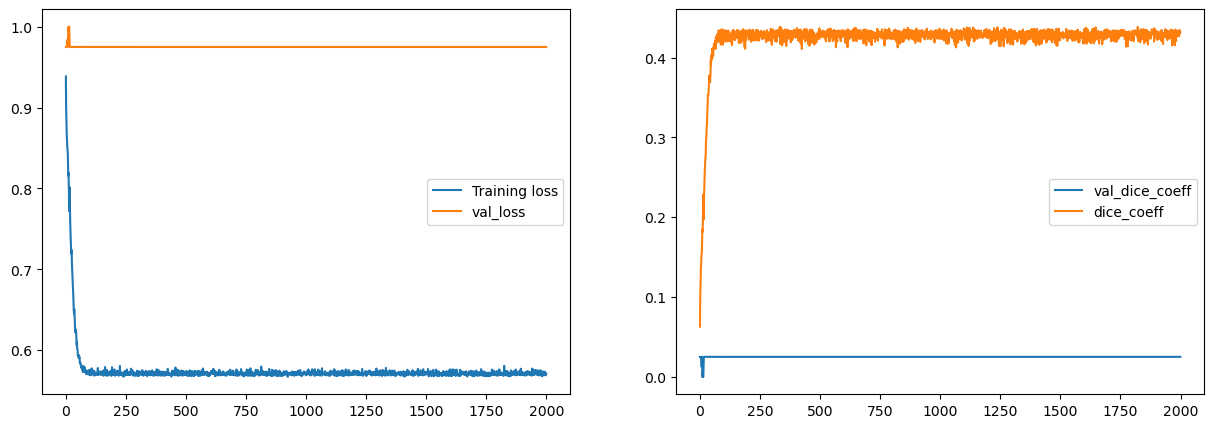

In [23]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

ax1.plot(model_history.history['loss'])
ax1.plot(model_history.history['val_loss'])
ax1.legend(['Training loss', 'val_loss'])

ax2.plot(model_history.history['val_dice_coeff'])
ax2.plot(model_history.history['dice_coeff'])
ax2.legend(['val_dice_coeff', 'dice_coeff'])

import pickle

# Save the history to a file
with open('model_history_2000_enhanced.pkl', 'wb') as file_pi:
    pickle.dump(model_history.history, file_pi)